# With the new control and armflapping videos (shorter directories), let's see whether we can get a higher accuracy. 

In [1]:
import cv2, os 
import numpy as np 
import warnings 
warnings.filterwarnings("ignore")

## create a function to detect all landmarks in a given frame 

In [2]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp


def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 42 # use 0 as default if the class is not there 
    Y_locations = [0] * 42 
    Z_locations = [0] * 42
    x = y = z = 0 
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y
                Z_locations[z] = landmark.z
                x += 1; y += 1; z += 1; 
    locations = np.concatenate([X_locations, Y_locations, Z_locations])
    hands.close()
    return locations 

In [3]:
# time to actually do calibration. 

SECONDS_TO_DETECT = 2 # in seconds
DISTANCE_BETWEEN_INPUTS = 0.01 # in seconds, only matters if sampling is True
sampling = False 

import os, cv2
from tqdm import tqdm 
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []
ARMFLAPPING_FPS = [] # store the FPS of all armflapping videos 
CONTROL_FPS = [] # store the FPS of all control videos 
for video_name in tqdm(os.listdir('behavior_data/shorter_armflapping'), desc = "armflapping_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/armflapping' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image) 
        
        ARMFLAPPING_VIDEOS.append(FRAMES)
        ARMFLAPPING_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")

for video_name in tqdm(os.listdir('behavior_data/control'), desc = "control_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_control/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image)
        
        CONTROL_VIDEOS.append(FRAMES)
        CONTROL_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")
    
len(ARMFLAPPING_VIDEOS), len(CONTROL_VIDEOS)

armflapping_videos:  18%|█▊        | 19/108 [00:00<00:02, 30.76it/s]

failed on .DS_Store


control_videos:  23%|██▎       | 14/62 [00:00<00:03, 15.42it/s]

failed on .DS_Store


control_videos: 100%|██████████| 62/62 [00:03<00:00, 19.67it/s]


(97, 50)

In [4]:
# get the locations of all of the videos 

ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS = [], []
for FRAMES in tqdm(ARMFLAPPING_VIDEOS) :
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    ARMFLAPPING_LOCATIONS.append(locs)

for FRAMES in tqdm(CONTROL_VIDEOS):  
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    CONTROL_LOCATIONS.append(locs)

100%|██████████| 50/50 [01:42<00:00,  2.04s/it]


In [8]:
print([len(video) for video in ARMFLAPPING_LOCATIONS])
print([len(video) for video in CONTROL_LOCATIONS])

[121, 61, 121, 90, 90, 90, 72, 90, 90, 49, 49, 90, 90, 90, 72, 90, 121, 49, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 121, 90, 90, 90, 90, 91, 90, 120, 90, 90, 121, 91, 90, 90, 90, 90, 45, 45, 121, 90, 90]
[121, 121, 90, 90, 72, 72, 90, 91, 49, 49, 49, 61, 45, 72, 72, 72, 73, 90, 60, 121, 90, 49, 90, 90, 73, 90, 73, 49, 121, 90, 90, 90, 60, 90, 121, 90, 41, 121, 45, 60, 121, 90, 90, 121, 90, 61, 46, 45, 45, 121]


In [5]:
# to balance classes 
N = min([len(locs) for locs in [ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS]])
ARMFLAPPING_LOCATIONS = ARMFLAPPING_LOCATIONS[:N]
CONTROL_LOCATIONS = CONTROL_LOCATIONS[:N]
ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)

## after balancing the classes, pad the data and convert to numpy arrays 

In [6]:
# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = np.array(locations).tolist() 
    empty_row = np.zeros((1, 126))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

padded_armflapping_locations = ARMFLAPPING_LOCATIONS
padded_control_locations = CONTROL_LOCATIONS
padded_armflapping_locations = pad(padded_armflapping_locations, maxlen = 90)
padded_control_locations = pad(padded_control_locations, maxlen = 90)
print(padded_control_locations.shape, padded_armflapping_locations.shape)
assert padded_armflapping_locations.shape == padded_control_locations.shape 

50it [00:00, 16694.41it/s]
50it [00:00, 7939.25it/s]

(50, 90, 126) (50, 90, 126)


In [13]:
from sklearn.model_selection import train_test_split

def generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS): 
    ARMFLAPPING_LABELS = np.ones(ARMFLAPPING_LOCATIONS.shape[0])
    CONTROL_LABELS = np.zeros(CONTROL_LOCATIONS.shape[0])
    
    # concatenate 
    data = np.concatenate([ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS])
    labels = np.concatenate([ARMFLAPPING_LABELS, CONTROL_LABELS])
    
    return data, labels 
X, y = generate_data(padded_armflapping_locations, padded_control_locations)

## function below to plot the model accuracy + loss through training. 

In [14]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    test_frames = []
    import cv2 

    cap = cv2.VideoCapture(path)

    while True: 
        _, frame = cap.read() 
        if not _: break 

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = hand_locations(frame)

        test_frames.append(frame)

    test_frames = np.array([test_frames])
    test_frames = pad(test_frames, maxlen = 90)
    
    return model.predict(test_frames)

## create the augmenter() class to do shift augmentations

In [16]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] 
        Y_locations = X[:, 42:84] 
        Z_locations = X[:, 84:]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:, 42:84] + mask * tf.ones_like(X[:, 42:84]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:, 42:84] - mask * tf.ones_like(X[:, 42:84]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:, :42] + mask * tf.ones_like(X[:, :42]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:, :42] - mask * tf.ones_like(X[:, :42]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move far
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:, 84:] + mask * tf.ones_like(X[:, 84:]) * move_far)
        else: 
            # move close 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:, 84:] - mask * tf.ones_like(X[:, 84:]) * move_close)

        return X



class Augmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X):
        return tf.map_fn(_shift, X)
        
        

In [17]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('all_points_folds'): 
    with open(f"all_points_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

## functions to plot the ROC and AURROC bar graph for each fold in a run, and for each run

In [36]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (No Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (No Aug)")
    plt.show()

## k-fold cross validation shown below

In [19]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [21]:
import random 
def shuffle(X, y, seed = None):
    if not seed:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 126)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y
X, y = shuffle(X, y, seed=65)

In [23]:
import tensorflow as tf 
def make_model(): 
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=False), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])

    model.compile(loss = "binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model 

## run 10 times to gather results!

In [37]:
plot_meta_roc_auroc(AVERAGE_AUROCS, AVERAGE_TPRS, np.linspace(0, 1, 101))

Epoch 1/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6844 - accuracy: 0.5250 - precision_1: 0.5333 - recall_1: 0.5854 - val_loss: 0.6953 - val_accuracy: 0.5000 - val_precision_1: 0.4706 - val_recall_1: 0.8889
Epoch 2/75
3/3 [==============================] - 0s 171ms/step - loss: 0.6641 - accuracy: 0.5750 - precision_1: 0.5467 - recall_1: 1.0000 - val_loss: 0.7007 - val_accuracy: 0.5000 - val_precision_1: 0.4706 - val_recall_1: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6430 - accuracy: 0.5375 - precision_1: 0.5270 - recall_1: 0.9512 - val_loss: 0.7052 - val_accuracy: 0.5000 - val_precision_1: 0.4706 - val_recall_1: 0.8889
Epoch 4/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6334 - accuracy: 0.5625 - precision_1: 0.5405 - recall_1: 0.9756 - val_loss: 0.7103 - val_accuracy: 0.5000 - val_precision_1: 0.4706 - val_recall_1: 0.8889
Epoch 5/75
3/3 [==============================] - 0s 171ms/step - loss: 0.6245 -

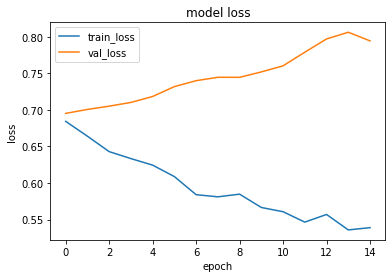

1it [00:00, 17476.27it/s]


prediction for video armflapping_1.mov is [[0.6164715]]


1it [00:00, 11650.84it/s]


prediction for video armflapping_3.mov is [[0.5366216]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_2.mov is [[0.49325794]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.23403066]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.72998357]]


1it [00:00, 12192.74it/s]


prediction for video control_3.mov is [[0.34421718]]
Epoch 1/75
3/3 [==============================] - 1s 281ms/step - loss: 0.6938 - accuracy: 0.4750 - precision_2: 0.4815 - recall_2: 0.6500 - val_loss: 0.6809 - val_accuracy: 0.5500 - val_precision_2: 0.5263 - val_recall_2: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6648 - accuracy: 0.5875 - precision_2: 0.5507 - recall_2: 0.9500 - val_loss: 0.6686 - val_accuracy: 0.5500 - val_precision_2: 0.5385 - val_recall_2: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6564 - accuracy: 0.6375 - precision_2: 0.5932 - recall_2: 0.8750 - val_loss: 0.6592 - val_accuracy: 0.6500 - val_precision_2: 0.6364 - val_recall_2: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6458 - accuracy: 0.7000 - precision_2: 0.6429 - recall_2: 0.9000 - val_loss: 0.6513 - val_accuracy: 0.6500 - val_precision_2: 0.6364 - val_recall_2: 0.7000
Epoch 5/75
3/3 [===========

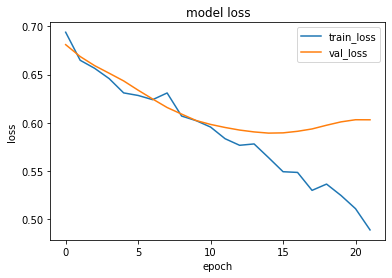

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.43441644]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.5787969]]


1it [00:00, 19599.55it/s]


prediction for video armflapping_2.mov is [[0.3118192]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.13901564]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.80784154]]


1it [00:00, 17924.38it/s]


prediction for video control_3.mov is [[0.22276065]]
Epoch 1/75
3/3 [==============================] - 1s 203ms/step - loss: 0.6807 - accuracy: 0.5750 - precision_3: 0.5745 - recall_3: 0.6585 - val_loss: 0.6647 - val_accuracy: 0.8500 - val_precision_3: 0.7500 - val_recall_3: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6777 - accuracy: 0.6500 - precision_3: 0.6444 - recall_3: 0.7073 - val_loss: 0.6504 - val_accuracy: 0.8500 - val_precision_3: 0.7500 - val_recall_3: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6663 - accuracy: 0.6750 - precision_3: 0.6531 - recall_3: 0.7805 - val_loss: 0.6400 - val_accuracy: 0.8500 - val_precision_3: 0.7500 - val_recall_3: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6472 - accuracy: 0.6625 - precision_3: 0.6458 - recall_3: 0.7561 - val_loss: 0.6305 - val_accuracy: 0.8500 - val_precision_3: 0.7500 - val_recall_3: 1.0000
Epoch 5/75
3/3 [===========

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.32382566]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.53389484]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_2.mov is [[0.19589123]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.13037276]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.83559084]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.16792122]]
Epoch 1/75
3/3 [==============================] - 1s 210ms/step - loss: 0.7170 - accuracy: 0.3500 - precision_4: 0.2000 - recall_4: 0.1000 - val_loss: 0.7343 - val_accuracy: 0.2500 - val_precision_4: 0.2222 - val_recall_4: 0.2000
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6955 - accuracy: 0.4250 - precision_4: 0.4250 - recall_4: 0.4250 - val_loss: 0.7104 - val_accuracy: 0.2500 - val_precision_4: 0.3077 - val_recall_4: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6785 - accuracy: 0.5250 - precision_4: 0.5192 - recall_4: 0.6750 - val_loss: 0.6908 - val_accuracy: 0.3500 - val_precision_4: 0.4000 - val_recall_4: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6744 - accuracy: 0.5125 - precision_4: 0.5088 - recall_4: 0.7250 - val_loss: 0.6746 - val_accuracy: 0.5000 - val_precision_4: 0.5000 - val_recall_4: 0.9000
Epoch 5/75
3/3 [===========

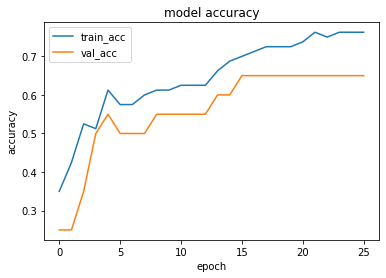

1it [00:00, 17476.27it/s]


prediction for video armflapping_1.mov is [[0.809165]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.5899918]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.43335712]]


1it [00:00, 17924.38it/s]


prediction for video control_1.mov is [[0.08204275]]


1it [00:00, 17924.38it/s]


prediction for video control_2.mov is [[0.78195155]]


1it [00:00, 17924.38it/s]


prediction for video control_3.mov is [[0.6646696]]
Epoch 1/75
3/3 [==============================] - 1s 223ms/step - loss: 0.6927 - accuracy: 0.4125 - precision_5: 0.3953 - recall_5: 0.4474 - val_loss: 0.6849 - val_accuracy: 0.5500 - val_precision_5: 0.6154 - val_recall_5: 0.6667
Epoch 2/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6835 - accuracy: 0.4875 - precision_5: 0.4762 - recall_5: 0.7895 - val_loss: 0.6668 - val_accuracy: 0.6500 - val_precision_5: 0.6471 - val_recall_5: 0.9167
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6641 - accuracy: 0.5500 - precision_5: 0.5172 - recall_5: 0.7895 - val_loss: 0.6514 - val_accuracy: 0.6500 - val_precision_5: 0.6667 - val_recall_5: 0.8333
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6685 - accuracy: 0.6500 - precision_5: 0.6000 - recall_5: 0.7895 - val_loss: 0.6410 - val_accuracy: 0.7000 - val_precision_5: 0.7143 - val_recall_5: 0.8333
Epoch 5/75
3/3 [============

1it [00:00, 18893.26it/s]


prediction for video armflapping_1.mov is [[0.14581943]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.60058755]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.11708426]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.06683317]]


1it [00:00, 17189.77it/s]


prediction for video control_2.mov is [[0.80269325]]


1it [00:00, 17476.27it/s]


prediction for video control_3.mov is [[0.07996315]]


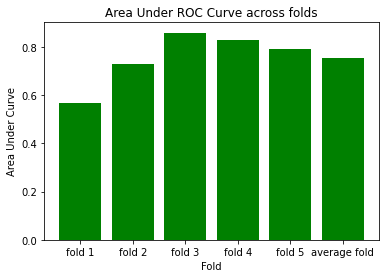

In [24]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 208ms/step - loss: 0.6784 - accuracy: 0.5375 - precision_7: 0.5270 - recall_7: 0.9512 - val_loss: 0.7076 - val_accuracy: 0.5500 - val_precision_7: 0.5000 - val_recall_7: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6684 - accuracy: 0.6750 - precision_7: 0.6271 - recall_7: 0.9024 - val_loss: 0.7096 - val_accuracy: 0.5500 - val_precision_7: 0.5000 - val_recall_7: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6405 - accuracy: 0.6875 - precision_7: 0.6429 - recall_7: 0.8780 - val_loss: 0.7080 - val_accuracy: 0.5500 - val_precision_7: 0.5000 - val_recall_7: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6270 - accuracy: 0.7125 - precision_7: 0.6667 - recall_7: 0.8780 - val_loss: 0.7095 - val_accuracy: 0.5500 - val_precision_7: 0.5000 - val_recall_7: 0.7778
Epoch 5/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6156 -

1it [00:00, 17924.38it/s]


prediction for video armflapping_1.mov is [[0.2833791]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_3.mov is [[0.64127874]]


1it [00:00, 17772.47it/s]


prediction for video armflapping_2.mov is [[0.20402113]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.09703058]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.8745781]]


1it [00:00, 18236.10it/s]


prediction for video control_3.mov is [[0.12923673]]
Epoch 1/75
3/3 [==============================] - 1s 204ms/step - loss: 0.6899 - accuracy: 0.4625 - precision_8: 0.4634 - recall_8: 0.4750 - val_loss: 0.6724 - val_accuracy: 0.5500 - val_precision_8: 0.5294 - val_recall_8: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6610 - accuracy: 0.5375 - precision_8: 0.5217 - recall_8: 0.9000 - val_loss: 0.6668 - val_accuracy: 0.5500 - val_precision_8: 0.5263 - val_recall_8: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6611 - accuracy: 0.5250 - precision_8: 0.5139 - recall_8: 0.9250 - val_loss: 0.6609 - val_accuracy: 0.5500 - val_precision_8: 0.5294 - val_recall_8: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6455 - accuracy: 0.6625 - precision_8: 0.6066 - recall_8: 0.9250 - val_loss: 0.6525 - val_accuracy: 0.7000 - val_precision_8: 0.7000 - val_recall_8: 0.7000
Epoch 5/75
3/3 [===========

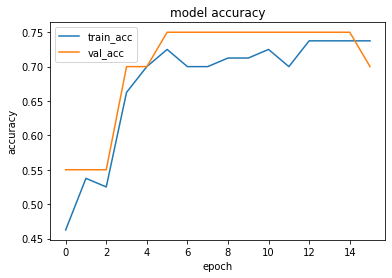

1it [00:00, 18808.54it/s]


prediction for video armflapping_1.mov is [[0.5044328]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.53887415]]


1it [00:00, 10837.99it/s]


prediction for video armflapping_2.mov is [[0.43164146]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.28016686]]


1it [00:00, 12826.62it/s]


prediction for video control_2.mov is [[0.74723214]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.33357623]]
Epoch 1/75
3/3 [==============================] - 1s 217ms/step - loss: 0.7124 - accuracy: 0.4125 - precision_9: 0.4118 - recall_9: 0.3415 - val_loss: 0.6828 - val_accuracy: 0.5500 - val_precision_9: 0.5000 - val_recall_9: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6816 - accuracy: 0.5000 - precision_9: 0.5070 - recall_9: 0.8780 - val_loss: 0.6672 - val_accuracy: 0.5500 - val_precision_9: 0.5000 - val_recall_9: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6858 - accuracy: 0.4750 - precision_9: 0.4925 - recall_9: 0.8049 - val_loss: 0.6574 - val_accuracy: 0.5500 - val_precision_9: 0.5000 - val_recall_9: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6757 - accuracy: 0.5625 - precision_9: 0.5455 - recall_9: 0.8780 - val_loss: 0.6482 - val_accuracy: 0.8000 - val_precision_9: 0.6923 - val_recall_9: 1.0000
Epoch 5/75
3/3 [===========

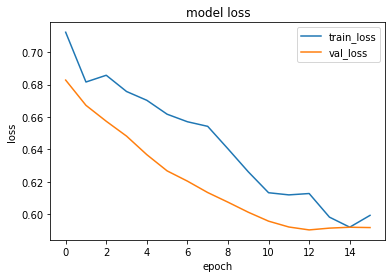

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.5453176]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_3.mov is [[0.5222229]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.4929533]]


1it [00:00, 17623.13it/s]


prediction for video control_1.mov is [[0.33154687]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.6512162]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.3623644]]
Epoch 1/75
3/3 [==============================] - 1s 202ms/step - loss: 0.6884 - accuracy: 0.5875 - precision_10: 0.5686 - recall_10: 0.7250 - val_loss: 0.6806 - val_accuracy: 0.7500 - val_precision_10: 0.6923 - val_recall_10: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6733 - accuracy: 0.7125 - precision_10: 0.6889 - recall_10: 0.7750 - val_loss: 0.6709 - val_accuracy: 0.7000 - val_precision_10: 0.6429 - val_recall_10: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6756 - accuracy: 0.6000 - precision_10: 0.5741 - recall_10: 0.7750 - val_loss: 0.6657 - val_accuracy: 0.6000 - val_precision_10: 0.5625 - val_recall_10: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6807 - accuracy: 0.5750 - precision_10: 0.5682 - recall_10: 0.6250 - val_loss: 0.6593 - val_accuracy: 0.6000 - val_precision_10: 0.5625 - val_recall_10: 0.9000
Epoch 5/75
3

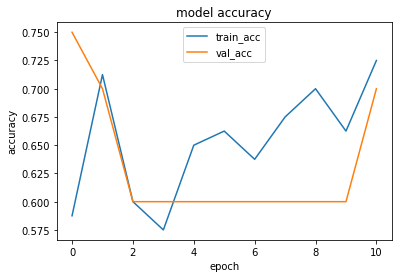

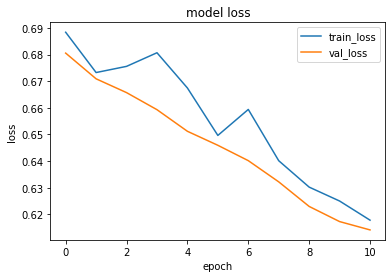

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.41690364]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.56164265]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.31362367]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.14606267]]


1it [00:00, 17476.27it/s]


prediction for video control_2.mov is [[0.7285609]]


1it [00:00, 17189.77it/s]


prediction for video control_3.mov is [[0.21949816]]
Epoch 1/75
3/3 [==============================] - 1s 206ms/step - loss: 0.6866 - accuracy: 0.5250 - precision_11: 0.5000 - recall_11: 0.4737 - val_loss: 0.6869 - val_accuracy: 0.5000 - val_precision_11: 0.7500 - val_recall_11: 0.2500
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6866 - accuracy: 0.6250 - precision_11: 0.6429 - recall_11: 0.4737 - val_loss: 0.6651 - val_accuracy: 0.7500 - val_precision_11: 0.7692 - val_recall_11: 0.8333
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6772 - accuracy: 0.6375 - precision_11: 0.6098 - recall_11: 0.6579 - val_loss: 0.6511 - val_accuracy: 0.7000 - val_precision_11: 0.7143 - val_recall_11: 0.8333
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6680 - accuracy: 0.6875 - precision_11: 0.6383 - recall_11: 0.7895 - val_loss: 0.6413 - val_accuracy: 0.7500 - val_precision_11: 0.7333 - val_recall_11: 0.9167
Epoch 5/75


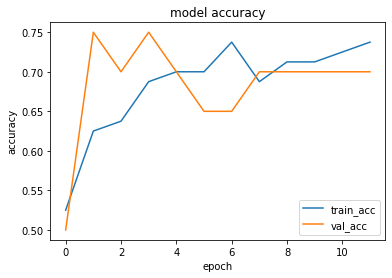

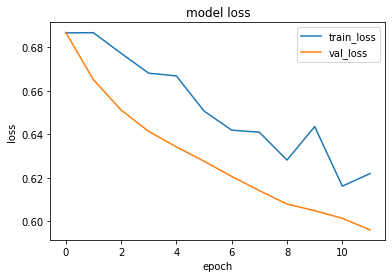

1it [00:00, 17189.77it/s]


prediction for video armflapping_1.mov is [[0.3020473]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.5335147]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.21863964]]


1it [00:00, 18236.10it/s]


prediction for video control_1.mov is [[0.11918315]]


1it [00:00, 18558.87it/s]


prediction for video control_2.mov is [[0.70935965]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.14898029]]


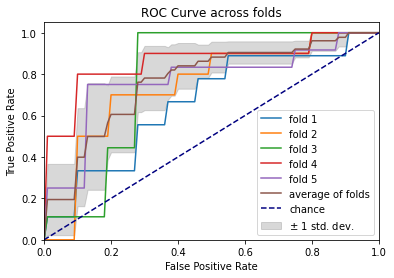

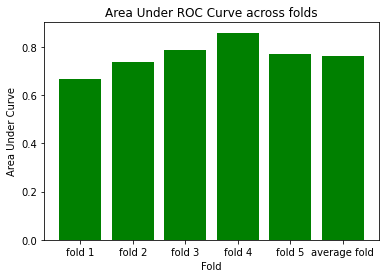

In [25]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 200ms/step - loss: 0.6949 - accuracy: 0.4125 - precision_13: 0.4211 - recall_13: 0.3902 - val_loss: 0.7025 - val_accuracy: 0.5500 - val_precision_13: 0.5000 - val_recall_13: 0.8889
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6652 - accuracy: 0.5250 - precision_13: 0.5217 - recall_13: 0.8780 - val_loss: 0.7098 - val_accuracy: 0.4500 - val_precision_13: 0.4444 - val_recall_13: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6485 - accuracy: 0.5875 - precision_13: 0.5541 - recall_13: 1.0000 - val_loss: 0.7064 - val_accuracy: 0.5500 - val_precision_13: 0.5000 - val_recall_13: 0.8889
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6448 - accuracy: 0.5750 - precision_13: 0.5467 - recall_13: 1.0000 - val_loss: 0.7023 - val_accuracy: 0.5500 - val_precision_13: 0.5000 - val_recall_13: 0.8889
Epoch 5/75
3/3 [==============================] - 0s 129ms/step 

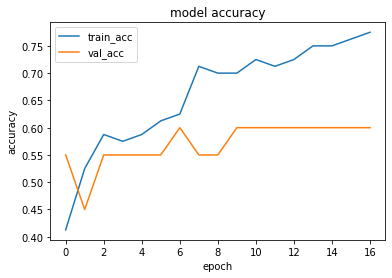

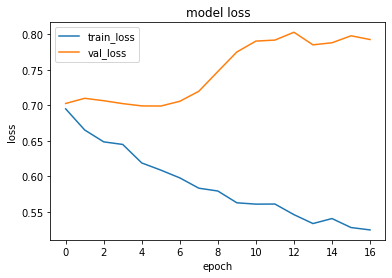

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.42212334]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.5591736]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.3755154]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.15847194]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.76169455]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.26126122]]
Epoch 1/75
3/3 [==============================] - 1s 206ms/step - loss: 0.6932 - accuracy: 0.5875 - precision_14: 0.5854 - recall_14: 0.6000 - val_loss: 0.6858 - val_accuracy: 0.6000 - val_precision_14: 0.5833 - val_recall_14: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6721 - accuracy: 0.6375 - precision_14: 0.5932 - recall_14: 0.8750 - val_loss: 0.6735 - val_accuracy: 0.6500 - val_precision_14: 0.6364 - val_recall_14: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6532 - accuracy: 0.6250 - precision_14: 0.5833 - recall_14: 0.8750 - val_loss: 0.6657 - val_accuracy: 0.6500 - val_precision_14: 0.6364 - val_recall_14: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6632 - accuracy: 0.6375 - precision_14: 0.5902 - recall_14: 0.9000 - val_loss: 0.6567 - val_accuracy: 0.6500 - val_precision_14: 0.6364 - val_recall_14: 0.7000
Epoch 5/75


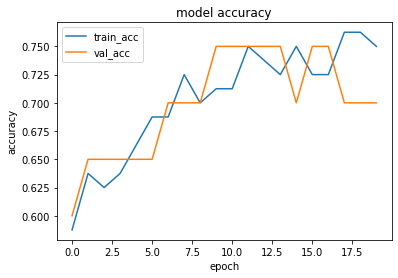

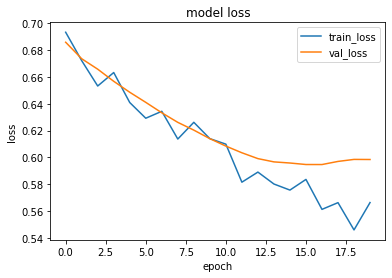

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.49948016]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.5516976]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_2.mov is [[0.37136662]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.19217676]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.7383464]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.25820482]]
Epoch 1/75
3/3 [==============================] - 1s 211ms/step - loss: 0.7058 - accuracy: 0.5125 - precision_15: 0.5167 - recall_15: 0.7561 - val_loss: 0.7192 - val_accuracy: 0.5000 - val_precision_15: 0.4737 - val_recall_15: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6895 - accuracy: 0.5375 - precision_15: 0.5303 - recall_15: 0.8537 - val_loss: 0.6950 - val_accuracy: 0.5000 - val_precision_15: 0.4737 - val_recall_15: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6740 - accuracy: 0.5750 - precision_15: 0.5538 - recall_15: 0.8780 - val_loss: 0.6745 - val_accuracy: 0.6000 - val_precision_15: 0.5294 - val_recall_15: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6674 - accuracy: 0.5250 - precision_15: 0.5224 - recall_15: 0.8537 - val_loss: 0.6574 - val_accuracy: 0.6000 - val_precision_15: 0.5294 - val_recall_15: 1.0000
Epoch 5/75


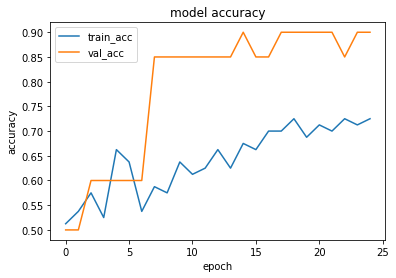

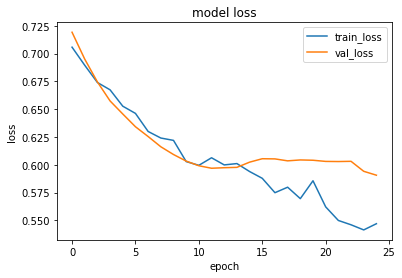

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.273629]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.58117366]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_2.mov is [[0.19408163]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.14869773]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.8832754]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.18648982]]
Epoch 1/75
3/3 [==============================] - 1s 214ms/step - loss: 0.6894 - accuracy: 0.4750 - precision_16: 0.4722 - recall_16: 0.4250 - val_loss: 0.6909 - val_accuracy: 0.3500 - val_precision_16: 0.4118 - val_recall_16: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6678 - accuracy: 0.6125 - precision_16: 0.5692 - recall_16: 0.9250 - val_loss: 0.6763 - val_accuracy: 0.4500 - val_precision_16: 0.4737 - val_recall_16: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6664 - accuracy: 0.5625 - precision_16: 0.5373 - recall_16: 0.9000 - val_loss: 0.6613 - val_accuracy: 0.5000 - val_precision_16: 0.5000 - val_recall_16: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6545 - accuracy: 0.5750 - precision_16: 0.5441 - recall_16: 0.9250 - val_loss: 0.6500 - val_accuracy: 0.5000 - val_precision_16: 0.5000 - val_recall_16: 1.0000
Epoch 5/75


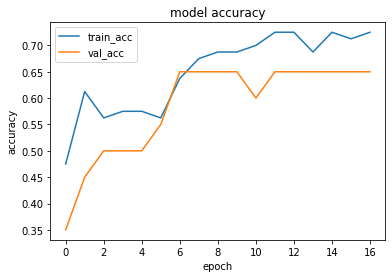

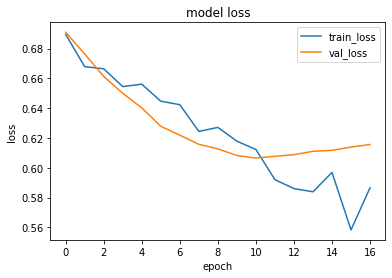

1it [00:00, 17623.13it/s]


prediction for video armflapping_1.mov is [[0.28471026]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.619011]]


1it [00:00, 12192.74it/s]


prediction for video armflapping_2.mov is [[0.18291092]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.07974789]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.76493907]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.1408248]]
Epoch 1/75
3/3 [==============================] - 1s 227ms/step - loss: 0.7029 - accuracy: 0.4250 - precision_17: 0.4091 - recall_17: 0.4737 - val_loss: 0.6769 - val_accuracy: 0.6000 - val_precision_17: 0.6250 - val_recall_17: 0.8333
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6745 - accuracy: 0.6500 - precision_17: 0.6087 - recall_17: 0.7368 - val_loss: 0.6658 - val_accuracy: 0.7500 - val_precision_17: 0.7692 - val_recall_17: 0.8333
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6630 - accuracy: 0.6750 - precision_17: 0.6304 - recall_17: 0.7632 - val_loss: 0.6527 - val_accuracy: 0.7500 - val_precision_17: 0.7333 - val_recall_17: 0.9167
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6699 - accuracy: 0.6875 - precision_17: 0.6275 - recall_17: 0.8421 - val_loss: 0.6401 - val_accuracy: 0.7500 - val_precision_17: 0.7333 - val_recall_17: 0.9167
Epoch 5/75
3

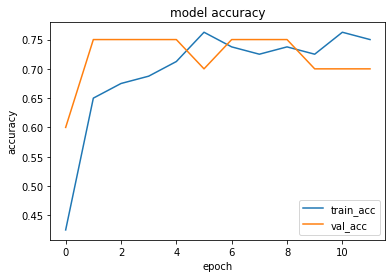

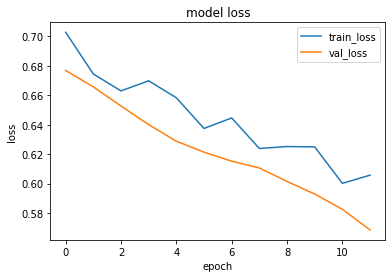

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.38608396]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_3.mov is [[0.5580213]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.22253612]]


1it [00:00, 16980.99it/s]


prediction for video control_1.mov is [[0.11809495]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.7642166]]


1it [00:00, 18558.87it/s]

prediction for video control_3.mov is [[0.18372604]]


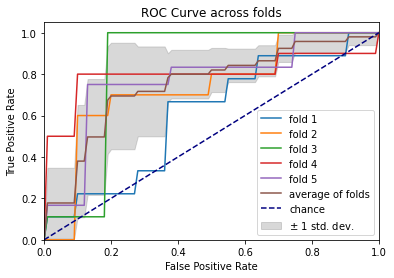

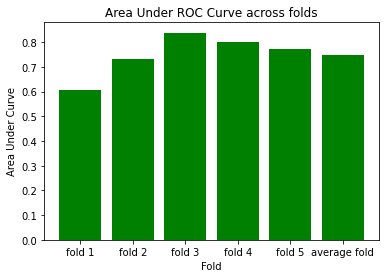

In [26]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 202ms/step - loss: 0.7029 - accuracy: 0.5375 - precision_19: 0.5263 - recall_19: 0.9756 - val_loss: 0.7112 - val_accuracy: 0.4500 - val_precision_19: 0.4500 - val_recall_19: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6757 - accuracy: 0.5875 - precision_19: 0.5588 - recall_19: 0.9268 - val_loss: 0.7045 - val_accuracy: 0.5500 - val_precision_19: 0.5000 - val_recall_19: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6494 - accuracy: 0.7000 - precision_19: 0.6545 - recall_19: 0.8780 - val_loss: 0.7037 - val_accuracy: 0.5500 - val_precision_19: 0.5000 - val_recall_19: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6431 - accuracy: 0.7000 - precision_19: 0.6604 - recall_19: 0.8537 - val_loss: 0.7032 - val_accuracy: 0.5500 - val_precision_19: 0.5000 - val_recall_19: 0.7778
Epoch 5/75
3/3 [==============================] - 0s 125ms/step 

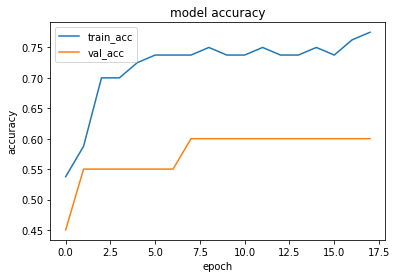

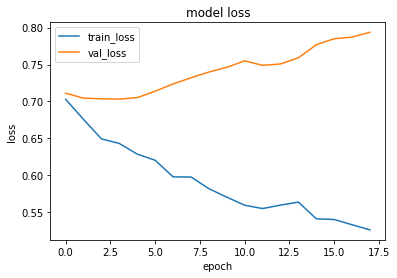

1it [00:00, 12372.58it/s]


prediction for video armflapping_1.mov is [[0.6080228]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.5499266]]


1it [00:00, 19152.07it/s]


prediction for video armflapping_2.mov is [[0.44768342]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.2296601]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.79721534]]


1it [00:00, 18236.10it/s]


prediction for video control_3.mov is [[0.3709786]]
Epoch 1/75
3/3 [==============================] - 1s 216ms/step - loss: 0.6912 - accuracy: 0.4875 - precision_20: 0.4894 - recall_20: 0.5750 - val_loss: 0.6856 - val_accuracy: 0.5500 - val_precision_20: 0.5263 - val_recall_20: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6798 - accuracy: 0.5875 - precision_20: 0.5556 - recall_20: 0.8750 - val_loss: 0.6751 - val_accuracy: 0.7000 - val_precision_20: 0.7000 - val_recall_20: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6673 - accuracy: 0.6750 - precision_20: 0.6296 - recall_20: 0.8500 - val_loss: 0.6673 - val_accuracy: 0.7000 - val_precision_20: 0.7000 - val_recall_20: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6531 - accuracy: 0.6875 - precision_20: 0.6364 - recall_20: 0.8750 - val_loss: 0.6611 - val_accuracy: 0.7000 - val_precision_20: 0.7000 - val_recall_20: 0.7000
Epoch 5/75
3

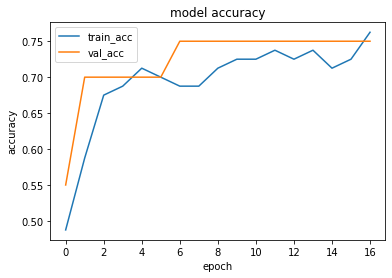

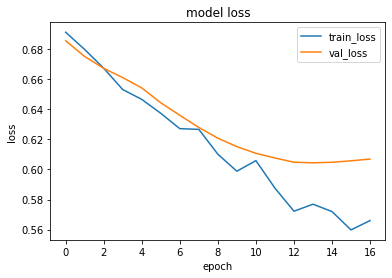

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.5210929]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_3.mov is [[0.52882725]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.44329596]]


1it [00:00, 17189.77it/s]


prediction for video control_1.mov is [[0.26010606]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.7226181]]


1it [00:00, 17772.47it/s]


prediction for video control_3.mov is [[0.36408296]]
Epoch 1/75
3/3 [==============================] - 1s 208ms/step - loss: 0.6745 - accuracy: 0.5375 - precision_21: 0.5312 - recall_21: 0.8293 - val_loss: 0.6746 - val_accuracy: 0.8000 - val_precision_21: 0.6923 - val_recall_21: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6545 - accuracy: 0.5875 - precision_21: 0.5667 - recall_21: 0.8293 - val_loss: 0.6625 - val_accuracy: 0.8000 - val_precision_21: 0.6923 - val_recall_21: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6537 - accuracy: 0.6750 - precision_21: 0.6364 - recall_21: 0.8537 - val_loss: 0.6515 - val_accuracy: 0.8000 - val_precision_21: 0.6923 - val_recall_21: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6445 - accuracy: 0.6625 - precision_21: 0.6346 - recall_21: 0.8049 - val_loss: 0.6417 - val_accuracy: 0.8000 - val_precision_21: 0.6923 - val_recall_21: 1.0000
Epoch 5/75


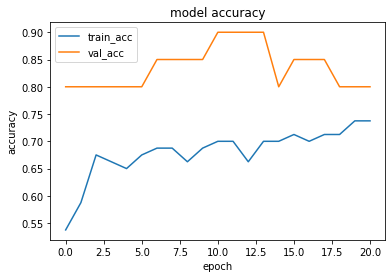

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.37357646]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.5564821]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_2.mov is [[0.2461347]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.17664158]]


1it [00:00, 17260.51it/s]


prediction for video control_2.mov is [[0.83839643]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.18696001]]
Epoch 1/75
3/3 [==============================] - 1s 209ms/step - loss: 0.7164 - accuracy: 0.5000 - precision_22: 0.5000 - recall_22: 0.7000 - val_loss: 0.6739 - val_accuracy: 0.7500 - val_precision_22: 0.6923 - val_recall_22: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6814 - accuracy: 0.6500 - precision_22: 0.6500 - recall_22: 0.6500 - val_loss: 0.6728 - val_accuracy: 0.7500 - val_precision_22: 0.6923 - val_recall_22: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6681 - accuracy: 0.6625 - precision_22: 0.6667 - recall_22: 0.6500 - val_loss: 0.6694 - val_accuracy: 0.6500 - val_precision_22: 0.6154 - val_recall_22: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6514 - accuracy: 0.7250 - precision_22: 0.7250 - recall_22: 0.7250 - val_loss: 0.6599 - val_accuracy: 0.6500 - val_precision_22: 0.6000 - val_recall_22: 0.9000
Epoch 5/75


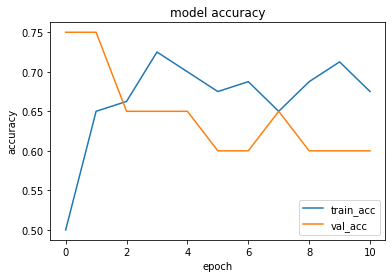

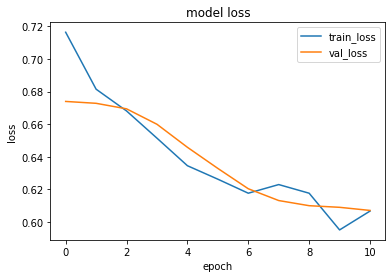

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.34950793]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.6135025]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_2.mov is [[0.22684771]]


1it [00:00, 16912.52it/s]


prediction for video control_1.mov is [[0.10234478]]


1it [00:00, 17260.51it/s]


prediction for video control_2.mov is [[0.79302466]]


1it [00:00, 17623.13it/s]


prediction for video control_3.mov is [[0.2112745]]
Epoch 1/75
3/3 [==============================] - 1s 199ms/step - loss: 0.6994 - accuracy: 0.5000 - precision_23: 0.4688 - recall_23: 0.3947 - val_loss: 0.6705 - val_accuracy: 0.6500 - val_precision_23: 0.6923 - val_recall_23: 0.7500
Epoch 2/75
3/3 [==============================] - 1s 124ms/step - loss: 0.6685 - accuracy: 0.6375 - precision_23: 0.6216 - recall_23: 0.6053 - val_loss: 0.6444 - val_accuracy: 0.7500 - val_precision_23: 0.7333 - val_recall_23: 0.9167
Epoch 3/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6680 - accuracy: 0.7125 - precision_23: 0.6471 - recall_23: 0.8684 - val_loss: 0.6236 - val_accuracy: 0.7000 - val_precision_23: 0.6875 - val_recall_23: 0.9167
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6796 - accuracy: 0.6750 - precision_23: 0.6200 - recall_23: 0.8158 - val_loss: 0.6089 - val_accuracy: 0.7000 - val_precision_23: 0.6875 - val_recall_23: 0.9167
Epoch 5/75
3

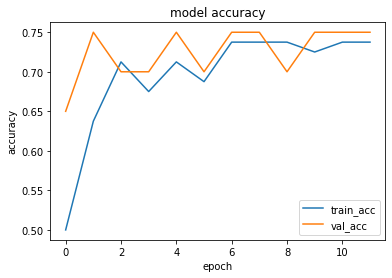

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.4741019]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.56630766]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_2.mov is [[0.26665837]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.13778237]]


1it [00:00, 17924.38it/s]


prediction for video control_2.mov is [[0.8149005]]


1it [00:00, 17549.39it/s]

prediction for video control_3.mov is [[0.20953634]]


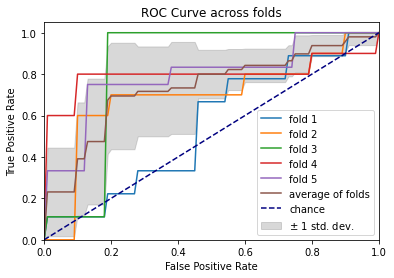

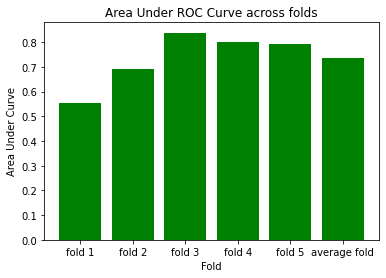

In [27]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 203ms/step - loss: 0.6533 - accuracy: 0.6250 - precision_25: 0.5902 - recall_25: 0.8780 - val_loss: 0.7141 - val_accuracy: 0.5000 - val_precision_25: 0.4667 - val_recall_25: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6325 - accuracy: 0.7250 - precision_25: 0.6792 - recall_25: 0.8780 - val_loss: 0.7116 - val_accuracy: 0.5500 - val_precision_25: 0.5000 - val_recall_25: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6147 - accuracy: 0.7250 - precision_25: 0.6863 - recall_25: 0.8537 - val_loss: 0.7090 - val_accuracy: 0.5500 - val_precision_25: 0.5000 - val_recall_25: 0.6667
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6124 - accuracy: 0.7125 - precision_25: 0.6731 - recall_25: 0.8537 - val_loss: 0.7077 - val_accuracy: 0.5500 - val_precision_25: 0.5000 - val_recall_25: 0.6667
Epoch 5/75
3/3 [==============================] - 0s 128ms/step 

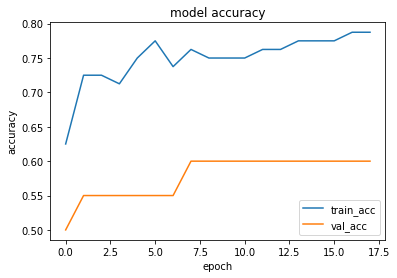

1it [00:00, 17924.38it/s]


prediction for video armflapping_1.mov is [[0.56358665]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.58096623]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.3185674]]


1it [00:00, 18236.10it/s]


prediction for video control_1.mov is [[0.11629391]]


1it [00:00, 18808.54it/s]


prediction for video control_2.mov is [[0.8053934]]


1it [00:00, 17924.38it/s]


prediction for video control_3.mov is [[0.23278204]]
Epoch 1/75
3/3 [==============================] - 1s 211ms/step - loss: 0.7092 - accuracy: 0.4000 - precision_26: 0.4048 - recall_26: 0.4250 - val_loss: 0.6951 - val_accuracy: 0.4500 - val_precision_26: 0.4737 - val_recall_26: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6880 - accuracy: 0.5250 - precision_26: 0.5161 - recall_26: 0.8000 - val_loss: 0.6830 - val_accuracy: 0.5500 - val_precision_26: 0.5294 - val_recall_26: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6584 - accuracy: 0.7375 - precision_26: 0.7021 - recall_26: 0.8250 - val_loss: 0.6739 - val_accuracy: 0.6500 - val_precision_26: 0.6667 - val_recall_26: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6478 - accuracy: 0.7625 - precision_26: 0.7143 - recall_26: 0.8750 - val_loss: 0.6657 - val_accuracy: 0.6500 - val_precision_26: 0.6667 - val_recall_26: 0.6000
Epoch 5/75


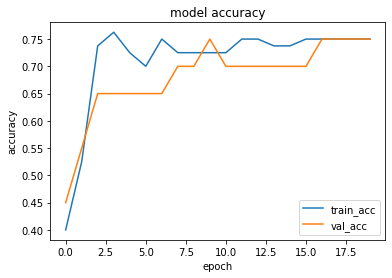

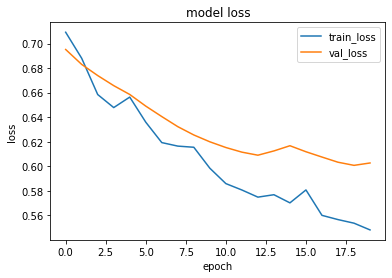

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.39436123]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_3.mov is [[0.5490708]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_2.mov is [[0.31372362]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.21582606]]


1it [00:00, 17623.13it/s]


prediction for video control_2.mov is [[0.79535913]]


1it [00:00, 18236.10it/s]


prediction for video control_3.mov is [[0.2397911]]
Epoch 1/75
3/3 [==============================] - 1s 219ms/step - loss: 0.7071 - accuracy: 0.4125 - precision_27: 0.4062 - recall_27: 0.3171 - val_loss: 0.6793 - val_accuracy: 0.8000 - val_precision_27: 0.7778 - val_recall_27: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6873 - accuracy: 0.4500 - precision_27: 0.4681 - recall_27: 0.5366 - val_loss: 0.6583 - val_accuracy: 0.7500 - val_precision_27: 0.6429 - val_recall_27: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 207ms/step - loss: 0.6784 - accuracy: 0.4875 - precision_27: 0.5000 - recall_27: 0.7561 - val_loss: 0.6423 - val_accuracy: 0.7500 - val_precision_27: 0.6429 - val_recall_27: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6607 - accuracy: 0.5750 - precision_27: 0.5574 - recall_27: 0.8293 - val_loss: 0.6318 - val_accuracy: 0.7500 - val_precision_27: 0.6429 - val_recall_27: 1.0000
Epoch 5/75
3

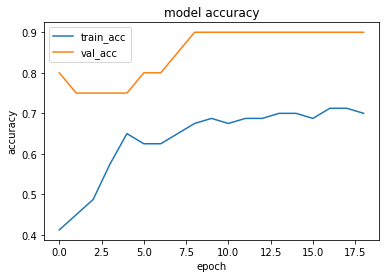

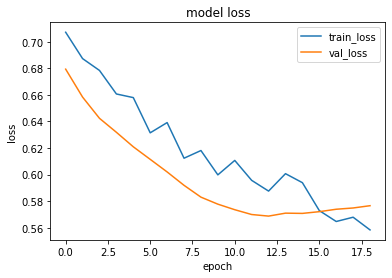

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.48532632]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.56649506]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_2.mov is [[0.31622458]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.1708698]]


1it [00:00, 17623.13it/s]


prediction for video control_2.mov is [[0.79628336]]


1it [00:00, 13706.88it/s]


prediction for video control_3.mov is [[0.26822504]]
Epoch 1/75
3/3 [==============================] - 1s 262ms/step - loss: 0.6926 - accuracy: 0.4500 - precision_28: 0.4655 - recall_28: 0.6750 - val_loss: 0.6713 - val_accuracy: 0.5000 - val_precision_28: 0.5000 - val_recall_28: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6802 - accuracy: 0.5375 - precision_28: 0.5246 - recall_28: 0.8000 - val_loss: 0.6668 - val_accuracy: 0.5000 - val_precision_28: 0.5000 - val_recall_28: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 164ms/step - loss: 0.6556 - accuracy: 0.6125 - precision_28: 0.5738 - recall_28: 0.8750 - val_loss: 0.6561 - val_accuracy: 0.5500 - val_precision_28: 0.5263 - val_recall_28: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6634 - accuracy: 0.6000 - precision_28: 0.5625 - recall_28: 0.9000 - val_loss: 0.6453 - val_accuracy: 0.5000 - val_precision_28: 0.5000 - val_recall_28: 1.0000
Epoch 5/75


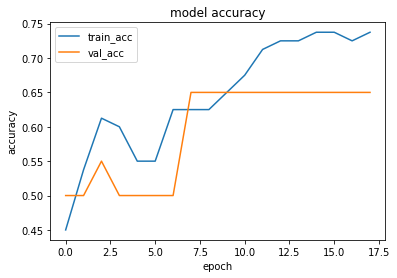

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.4072216]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.62265205]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.14575249]]


1it [00:00, 17623.13it/s]


prediction for video control_1.mov is [[0.10306859]]


1it [00:00, 17924.38it/s]


prediction for video control_2.mov is [[0.8433829]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.14549127]]
Epoch 1/75
3/3 [==============================] - 1s 215ms/step - loss: 0.7017 - accuracy: 0.4125 - precision_29: 0.3953 - recall_29: 0.4474 - val_loss: 0.6699 - val_accuracy: 0.7000 - val_precision_29: 0.6875 - val_recall_29: 0.9167
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6667 - accuracy: 0.5125 - precision_29: 0.4923 - recall_29: 0.8421 - val_loss: 0.6532 - val_accuracy: 0.6500 - val_precision_29: 0.6667 - val_recall_29: 0.8333
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6658 - accuracy: 0.6500 - precision_29: 0.6087 - recall_29: 0.7368 - val_loss: 0.6450 - val_accuracy: 0.7000 - val_precision_29: 0.7143 - val_recall_29: 0.8333
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6557 - accuracy: 0.6750 - precision_29: 0.6429 - recall_29: 0.7105 - val_loss: 0.6357 - val_accuracy: 0.7000 - val_precision_29: 0.7143 - val_recall_29: 0.8333
Epoch 5/75


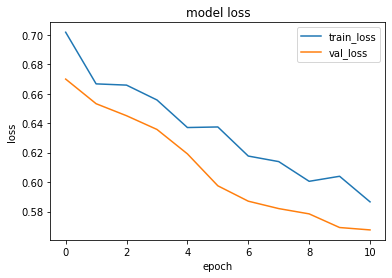

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.21574533]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.5858946]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_2.mov is [[0.151075]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.10058567]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.8218417]]


1it [00:00, 16644.06it/s]


prediction for video control_3.mov is [[0.12860134]]


In [28]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 327ms/step - loss: 0.6931 - accuracy: 0.4500 - precision_31: 0.4769 - recall_31: 0.7561 - val_loss: 0.6930 - val_accuracy: 0.5000 - val_precision_31: 0.4737 - val_recall_31: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 168ms/step - loss: 0.6631 - accuracy: 0.5375 - precision_31: 0.5270 - recall_31: 0.9512 - val_loss: 0.6880 - val_accuracy: 0.5000 - val_precision_31: 0.4706 - val_recall_31: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6484 - accuracy: 0.5875 - precision_31: 0.5588 - recall_31: 0.9268 - val_loss: 0.6885 - val_accuracy: 0.5500 - val_precision_31: 0.5000 - val_recall_31: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6382 - accuracy: 0.6625 - precision_31: 0.6207 - recall_31: 0.8780 - val_loss: 0.6895 - val_accuracy: 0.6000 - val_precision_31: 0.5385 - val_recall_31: 0.7778
Epoch 5/75
3/3 [==============================] - 1s 165ms/step 

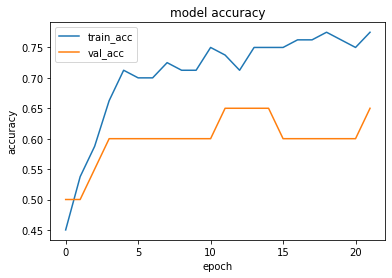

1it [00:00, 18808.54it/s]


prediction for video armflapping_1.mov is [[0.350424]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.5971488]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.2437534]]


1it [00:00, 12157.40it/s]


prediction for video control_1.mov is [[0.0988223]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.8571239]]


1it [00:00, 16980.99it/s]


prediction for video control_3.mov is [[0.14892304]]
Epoch 1/75
3/3 [==============================] - 1s 204ms/step - loss: 0.7201 - accuracy: 0.4500 - precision_32: 0.4167 - recall_32: 0.2500 - val_loss: 0.6910 - val_accuracy: 0.6000 - val_precision_32: 0.7500 - val_recall_32: 0.3000
Epoch 2/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6903 - accuracy: 0.5375 - precision_32: 0.5333 - recall_32: 0.6000 - val_loss: 0.6816 - val_accuracy: 0.6000 - val_precision_32: 0.5556 - val_recall_32: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6829 - accuracy: 0.5250 - precision_32: 0.5167 - recall_32: 0.7750 - val_loss: 0.6700 - val_accuracy: 0.6000 - val_precision_32: 0.5625 - val_recall_32: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6651 - accuracy: 0.5250 - precision_32: 0.5143 - recall_32: 0.9000 - val_loss: 0.6580 - val_accuracy: 0.7000 - val_precision_32: 0.7000 - val_recall_32: 0.7000
Epoch 5/75


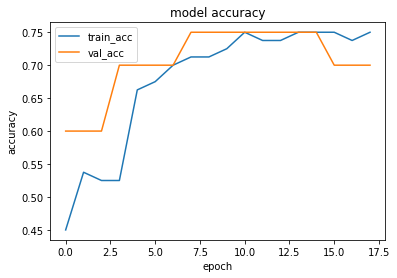

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.54410523]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.5535421]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_2.mov is [[0.36489934]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.19773975]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.7449282]]


1it [00:00, 17331.83it/s]


prediction for video control_3.mov is [[0.38762712]]
Epoch 1/75
3/3 [==============================] - 1s 220ms/step - loss: 0.6892 - accuracy: 0.6125 - precision_33: 0.5893 - recall_33: 0.8049 - val_loss: 0.6624 - val_accuracy: 0.8500 - val_precision_33: 0.7500 - val_recall_33: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6749 - accuracy: 0.6500 - precision_33: 0.6383 - recall_33: 0.7317 - val_loss: 0.6445 - val_accuracy: 0.8500 - val_precision_33: 0.7500 - val_recall_33: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6663 - accuracy: 0.6750 - precision_33: 0.6667 - recall_33: 0.7317 - val_loss: 0.6366 - val_accuracy: 0.8500 - val_precision_33: 0.7500 - val_recall_33: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6544 - accuracy: 0.6875 - precision_33: 0.6667 - recall_33: 0.7805 - val_loss: 0.6279 - val_accuracy: 0.8500 - val_precision_33: 0.7500 - val_recall_33: 1.0000
Epoch 5/75


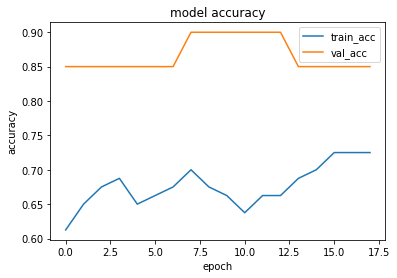

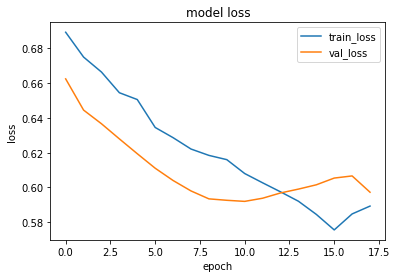

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.34794497]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_3.mov is [[0.52296966]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_2.mov is [[0.28186303]]


1it [00:00, 17189.77it/s]


prediction for video control_1.mov is [[0.17712581]]


1it [00:00, 17623.13it/s]


prediction for video control_2.mov is [[0.7605052]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.21913889]]
Epoch 1/75
3/3 [==============================] - 1s 290ms/step - loss: 0.6946 - accuracy: 0.5625 - precision_34: 0.5410 - recall_34: 0.8250 - val_loss: 0.6904 - val_accuracy: 0.3500 - val_precision_34: 0.4118 - val_recall_34: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6803 - accuracy: 0.5625 - precision_34: 0.5490 - recall_34: 0.7000 - val_loss: 0.6955 - val_accuracy: 0.4000 - val_precision_34: 0.4167 - val_recall_34: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6838 - accuracy: 0.5500 - precision_34: 0.5357 - recall_34: 0.7500 - val_loss: 0.6899 - val_accuracy: 0.3000 - val_precision_34: 0.3750 - val_recall_34: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6697 - accuracy: 0.5250 - precision_34: 0.5172 - recall_34: 0.7500 - val_loss: 0.6886 - val_accuracy: 0.3500 - val_precision_34: 0.4000 - val_recall_34: 0.6000
Epoch 5/75


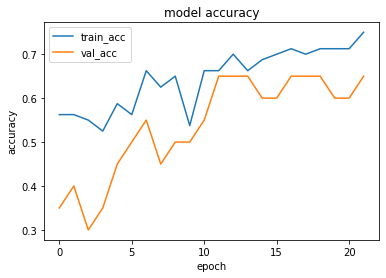

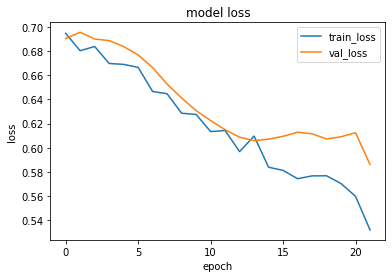

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.5200259]]


1it [00:00, 6754.11it/s]


prediction for video armflapping_3.mov is [[0.6242657]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.27788]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.04305047]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.80082846]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.08102396]]
Epoch 1/75
3/3 [==============================] - 1s 220ms/step - loss: 0.6938 - accuracy: 0.6250 - precision_35: 0.7857 - recall_35: 0.2895 - val_loss: 0.6939 - val_accuracy: 0.5000 - val_precision_35: 1.0000 - val_recall_35: 0.1667
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6880 - accuracy: 0.6250 - precision_35: 0.6429 - recall_35: 0.4737 - val_loss: 0.6729 - val_accuracy: 0.6000 - val_precision_35: 0.7500 - val_recall_35: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6715 - accuracy: 0.6875 - precision_35: 0.6757 - recall_35: 0.6579 - val_loss: 0.6562 - val_accuracy: 0.6500 - val_precision_35: 0.7778 - val_recall_35: 0.5833
Epoch 4/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6561 - accuracy: 0.7375 - precision_35: 0.6977 - recall_35: 0.7895 - val_loss: 0.6439 - val_accuracy: 0.6500 - val_precision_35: 0.7273 - val_recall_35: 0.6667
Epoch 5/75


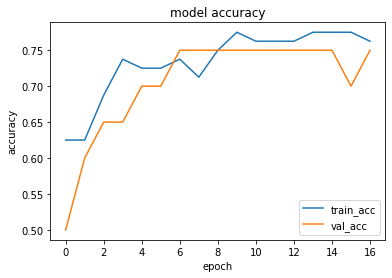

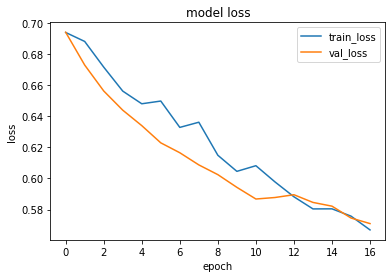

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.20249072]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_3.mov is [[0.5354351]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_2.mov is [[0.16979879]]


1it [00:00, 17924.38it/s]


prediction for video control_1.mov is [[0.12834185]]


1it [00:00, 9078.58it/s]


prediction for video control_2.mov is [[0.8137688]]


1it [00:00, 9078.58it/s]


prediction for video control_3.mov is [[0.1629839]]


In [29]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 210ms/step - loss: 0.6977 - accuracy: 0.3625 - precision_37: 0.3750 - recall_37: 0.3659 - val_loss: 0.6743 - val_accuracy: 0.5000 - val_precision_37: 0.4444 - val_recall_37: 0.4444
Epoch 2/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6835 - accuracy: 0.4625 - precision_37: 0.4833 - recall_37: 0.7073 - val_loss: 0.6768 - val_accuracy: 0.4500 - val_precision_37: 0.4286 - val_recall_37: 0.6667
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6565 - accuracy: 0.5250 - precision_37: 0.5205 - recall_37: 0.9268 - val_loss: 0.6821 - val_accuracy: 0.5000 - val_precision_37: 0.4706 - val_recall_37: 0.8889
Epoch 4/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6346 - accuracy: 0.5500 - precision_37: 0.5333 - recall_37: 0.9756 - val_loss: 0.6887 - val_accuracy: 0.5000 - val_precision_37: 0.4706 - val_recall_37: 0.8889
Epoch 5/75
3/3 [==============================] - 0s 149ms/step 

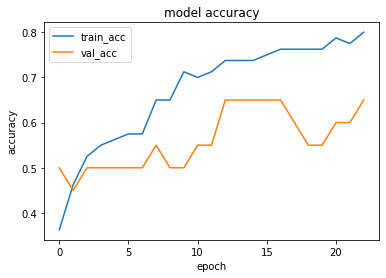

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.24776372]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.6146574]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_2.mov is [[0.1333799]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.05503017]]


1it [00:00, 18808.54it/s]


prediction for video control_2.mov is [[0.884678]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.08904681]]
Epoch 1/75
3/3 [==============================] - 1s 210ms/step - loss: 0.7217 - accuracy: 0.4625 - precision_38: 0.4211 - recall_38: 0.2000 - val_loss: 0.7047 - val_accuracy: 0.4500 - val_precision_38: 0.3333 - val_recall_38: 0.1000
Epoch 2/75
3/3 [==============================] - 0s 132ms/step - loss: 0.7060 - accuracy: 0.4875 - precision_38: 0.4783 - recall_38: 0.2750 - val_loss: 0.6922 - val_accuracy: 0.5000 - val_precision_38: 0.5000 - val_recall_38: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6790 - accuracy: 0.6500 - precision_38: 0.6765 - recall_38: 0.5750 - val_loss: 0.6800 - val_accuracy: 0.6500 - val_precision_38: 0.6667 - val_recall_38: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6602 - accuracy: 0.6875 - precision_38: 0.6744 - recall_38: 0.7250 - val_loss: 0.6686 - val_accuracy: 0.7000 - val_precision_38: 0.7000 - val_recall_38: 0.7000
Epoch 5/75


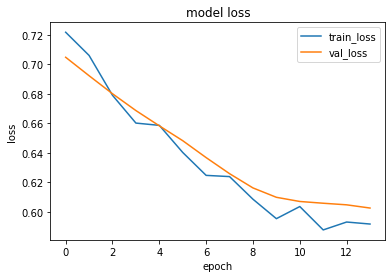

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.5047474]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.5180611]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.5179611]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.3274426]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.5553468]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.4570652]]
Epoch 1/75
3/3 [==============================] - 1s 267ms/step - loss: 0.6994 - accuracy: 0.5000 - precision_39: 0.5098 - recall_39: 0.6341 - val_loss: 0.6619 - val_accuracy: 0.8000 - val_precision_39: 0.6923 - val_recall_39: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6618 - accuracy: 0.7000 - precision_39: 0.6809 - recall_39: 0.7805 - val_loss: 0.6406 - val_accuracy: 0.8000 - val_precision_39: 0.6923 - val_recall_39: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6705 - accuracy: 0.6375 - precision_39: 0.6154 - recall_39: 0.7805 - val_loss: 0.6261 - val_accuracy: 0.8000 - val_precision_39: 0.6923 - val_recall_39: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 240ms/step - loss: 0.6490 - accuracy: 0.6500 - precision_39: 0.6182 - recall_39: 0.8293 - val_loss: 0.6211 - val_accuracy: 0.8000 - val_precision_39: 0.6923 - val_recall_39: 1.0000
Epoch 5/75
3

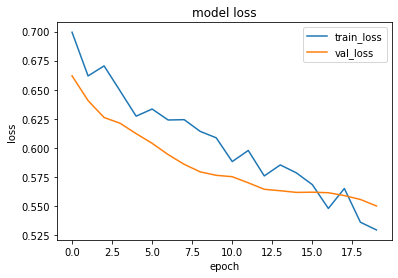

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.4322773]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_3.mov is [[0.5825169]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_2.mov is [[0.2876149]]


1it [00:00, 17331.83it/s]


prediction for video control_1.mov is [[0.16557226]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.83222896]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.24681792]]
Epoch 1/75
3/3 [==============================] - 1s 210ms/step - loss: 0.7046 - accuracy: 0.5750 - precision_40: 0.5484 - recall_40: 0.8500 - val_loss: 0.6678 - val_accuracy: 0.7000 - val_precision_40: 0.6429 - val_recall_40: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6814 - accuracy: 0.6500 - precision_40: 0.6111 - recall_40: 0.8250 - val_loss: 0.6705 - val_accuracy: 0.7000 - val_precision_40: 0.6429 - val_recall_40: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6827 - accuracy: 0.6250 - precision_40: 0.5962 - recall_40: 0.7750 - val_loss: 0.6656 - val_accuracy: 0.6500 - val_precision_40: 0.6000 - val_recall_40: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6597 - accuracy: 0.6750 - precision_40: 0.6458 - recall_40: 0.7750 - val_loss: 0.6635 - val_accuracy: 0.6000 - val_precision_40: 0.5625 - val_recall_40: 0.9000
Epoch 5/75


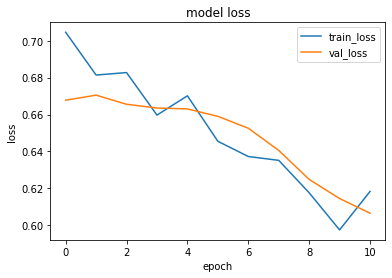

1it [00:00, 16912.52it/s]


prediction for video armflapping_1.mov is [[0.44989732]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.6192098]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_2.mov is [[0.25931007]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.12884587]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.80551]]


1it [00:00, 17772.47it/s]


prediction for video control_3.mov is [[0.22698316]]
Epoch 1/75
3/3 [==============================] - 1s 225ms/step - loss: 0.6817 - accuracy: 0.4375 - precision_41: 0.4426 - recall_41: 0.7105 - val_loss: 0.6649 - val_accuracy: 0.6500 - val_precision_41: 0.6316 - val_recall_41: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6704 - accuracy: 0.5375 - precision_41: 0.5068 - recall_41: 0.9737 - val_loss: 0.6564 - val_accuracy: 0.7000 - val_precision_41: 0.6875 - val_recall_41: 0.9167
Epoch 3/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6709 - accuracy: 0.6750 - precision_41: 0.6250 - recall_41: 0.7895 - val_loss: 0.6511 - val_accuracy: 0.6500 - val_precision_41: 0.6667 - val_recall_41: 0.8333
Epoch 4/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6564 - accuracy: 0.7125 - precision_41: 0.6596 - recall_41: 0.8158 - val_loss: 0.6480 - val_accuracy: 0.6500 - val_precision_41: 0.6923 - val_recall_41: 0.7500
Epoch 5/75


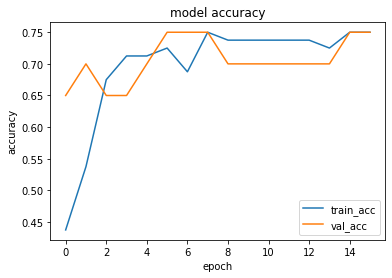

1it [00:00, 17476.27it/s]


prediction for video armflapping_1.mov is [[0.2885272]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.5483898]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.18757889]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.11109331]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.7804396]]


1it [00:00, 11491.24it/s]


prediction for video control_3.mov is [[0.15195814]]


In [30]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 205ms/step - loss: 0.6895 - accuracy: 0.5250 - precision_43: 0.7143 - recall_43: 0.1220 - val_loss: 0.6936 - val_accuracy: 0.5000 - val_precision_43: 0.4545 - val_recall_43: 0.5556
Epoch 2/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6688 - accuracy: 0.6125 - precision_43: 0.5962 - recall_43: 0.7561 - val_loss: 0.7063 - val_accuracy: 0.5500 - val_precision_43: 0.5000 - val_recall_43: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6481 - accuracy: 0.5625 - precision_43: 0.5405 - recall_43: 0.9756 - val_loss: 0.7170 - val_accuracy: 0.5000 - val_precision_43: 0.4706 - val_recall_43: 0.8889
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6334 - accuracy: 0.5625 - precision_43: 0.5395 - recall_43: 1.0000 - val_loss: 0.7203 - val_accuracy: 0.5000 - val_precision_43: 0.4706 - val_recall_43: 0.8889
Epoch 5/75
3/3 [==============================] - 0s 125ms/step 

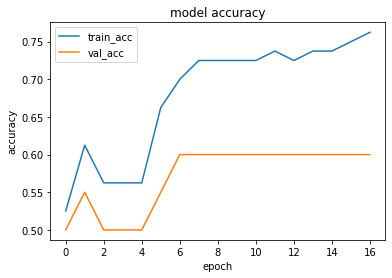

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.5245097]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_3.mov is [[0.54694676]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.46070606]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.19743454]]


1it [00:00, 9098.27it/s]


prediction for video control_2.mov is [[0.7463331]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.2686184]]
Epoch 1/75
3/3 [==============================] - 1s 210ms/step - loss: 0.6919 - accuracy: 0.6250 - precision_44: 0.5926 - recall_44: 0.8000 - val_loss: 0.6834 - val_accuracy: 0.6500 - val_precision_44: 0.6667 - val_recall_44: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6685 - accuracy: 0.7500 - precision_44: 0.7000 - recall_44: 0.8750 - val_loss: 0.6727 - val_accuracy: 0.6500 - val_precision_44: 0.6667 - val_recall_44: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6553 - accuracy: 0.7125 - precision_44: 0.6735 - recall_44: 0.8250 - val_loss: 0.6630 - val_accuracy: 0.6500 - val_precision_44: 0.6667 - val_recall_44: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6550 - accuracy: 0.7250 - precision_44: 0.6875 - recall_44: 0.8250 - val_loss: 0.6545 - val_accuracy: 0.6500 - val_precision_44: 0.6667 - val_recall_44: 0.6000
Epoch 5/75
3

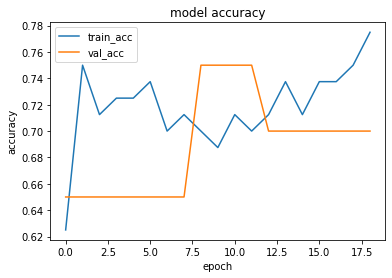

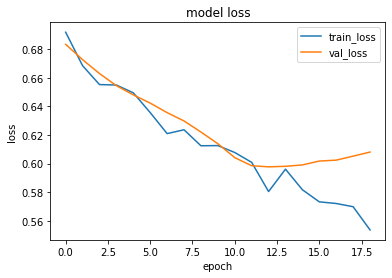

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.43723154]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.5417506]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.32265663]]


1it [00:00, 18236.10it/s]


prediction for video control_1.mov is [[0.14232153]]


1it [00:00, 18808.54it/s]


prediction for video control_2.mov is [[0.7830192]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.26007378]]
Epoch 1/75
3/3 [==============================] - 1s 210ms/step - loss: 0.7025 - accuracy: 0.5750 - precision_45: 0.6129 - recall_45: 0.4634 - val_loss: 0.6925 - val_accuracy: 0.7000 - val_precision_45: 0.6364 - val_recall_45: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6668 - accuracy: 0.6500 - precision_45: 0.6383 - recall_45: 0.7317 - val_loss: 0.6782 - val_accuracy: 0.8000 - val_precision_45: 0.6923 - val_recall_45: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6636 - accuracy: 0.6250 - precision_45: 0.6038 - recall_45: 0.7805 - val_loss: 0.6656 - val_accuracy: 0.8500 - val_precision_45: 0.7500 - val_recall_45: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6552 - accuracy: 0.6625 - precision_45: 0.6458 - recall_45: 0.7561 - val_loss: 0.6536 - val_accuracy: 0.8500 - val_precision_45: 0.7500 - val_recall_45: 1.0000
Epoch 5/75


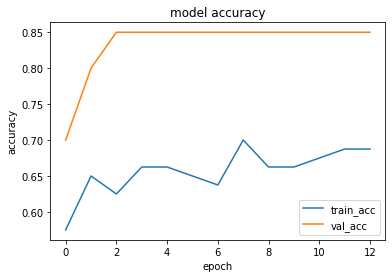

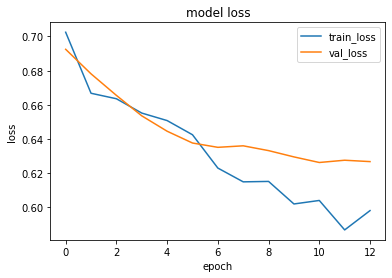

1it [00:00, 17924.38it/s]


prediction for video armflapping_1.mov is [[0.5205156]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.5173573]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_2.mov is [[0.46501562]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.4314265]]


1it [00:00, 9078.58it/s]


prediction for video control_2.mov is [[0.6576866]]


1it [00:00, 18808.54it/s]


prediction for video control_3.mov is [[0.42417932]]
Epoch 1/75
3/3 [==============================] - 1s 211ms/step - loss: 0.7121 - accuracy: 0.4375 - precision_46: 0.4390 - recall_46: 0.4500 - val_loss: 0.6910 - val_accuracy: 0.3500 - val_precision_46: 0.4000 - val_recall_46: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6770 - accuracy: 0.5375 - precision_46: 0.5246 - recall_46: 0.8000 - val_loss: 0.6866 - val_accuracy: 0.4000 - val_precision_46: 0.4375 - val_recall_46: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6877 - accuracy: 0.5000 - precision_46: 0.5000 - recall_46: 0.7500 - val_loss: 0.6752 - val_accuracy: 0.4500 - val_precision_46: 0.4706 - val_recall_46: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6552 - accuracy: 0.6250 - precision_46: 0.5758 - recall_46: 0.9500 - val_loss: 0.6692 - val_accuracy: 0.4500 - val_precision_46: 0.4706 - val_recall_46: 0.8000
Epoch 5/75


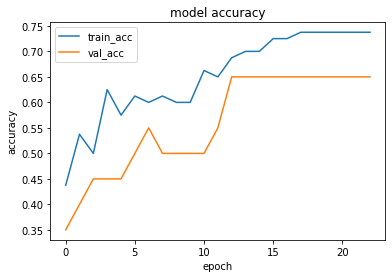

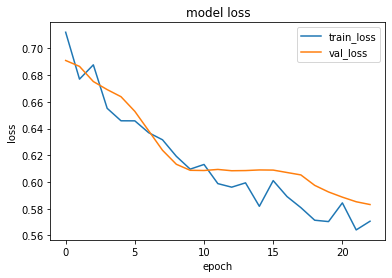

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.32569876]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.61560094]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_2.mov is [[0.3162675]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.11154664]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.8119582]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.3190509]]
Epoch 1/75
3/3 [==============================] - 1s 203ms/step - loss: 0.6956 - accuracy: 0.5750 - precision_47: 0.5588 - recall_47: 0.5000 - val_loss: 0.6679 - val_accuracy: 0.7500 - val_precision_47: 0.7692 - val_recall_47: 0.8333
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6762 - accuracy: 0.6125 - precision_47: 0.6129 - recall_47: 0.5000 - val_loss: 0.6540 - val_accuracy: 0.7500 - val_precision_47: 0.7333 - val_recall_47: 0.9167
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6683 - accuracy: 0.7000 - precision_47: 0.6667 - recall_47: 0.7368 - val_loss: 0.6447 - val_accuracy: 0.7000 - val_precision_47: 0.7143 - val_recall_47: 0.8333
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6523 - accuracy: 0.7625 - precision_47: 0.7111 - recall_47: 0.8421 - val_loss: 0.6311 - val_accuracy: 0.7000 - val_precision_47: 0.7143 - val_recall_47: 0.8333
Epoch 5/75
3

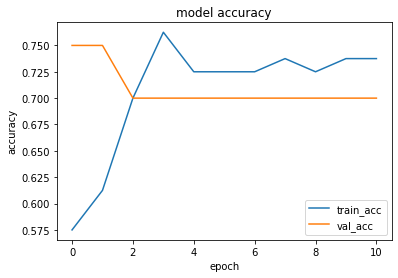

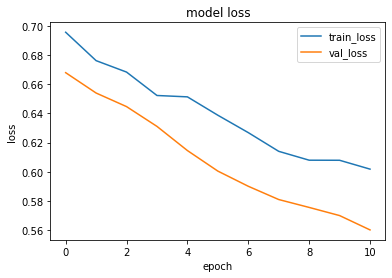

1it [00:00, 17476.27it/s]


prediction for video armflapping_1.mov is [[0.36294967]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.5610698]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.25824463]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.14559704]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.776963]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.19012728]]


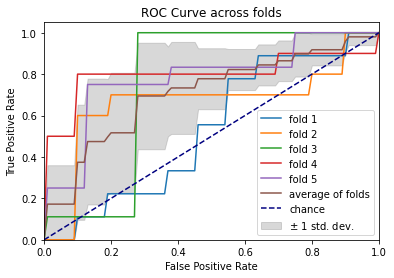

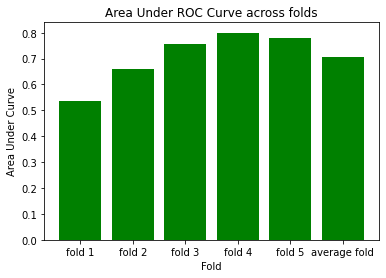

In [31]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 200ms/step - loss: 0.7034 - accuracy: 0.3750 - precision_49: 0.3043 - recall_49: 0.1707 - val_loss: 0.6900 - val_accuracy: 0.4000 - val_precision_49: 0.3636 - val_recall_49: 0.4444
Epoch 2/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6811 - accuracy: 0.4375 - precision_49: 0.4655 - recall_49: 0.6585 - val_loss: 0.6977 - val_accuracy: 0.5000 - val_precision_49: 0.4667 - val_recall_49: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6527 - accuracy: 0.5375 - precision_49: 0.5294 - recall_49: 0.8780 - val_loss: 0.7105 - val_accuracy: 0.5500 - val_precision_49: 0.5000 - val_recall_49: 0.8889
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6436 - accuracy: 0.5500 - precision_49: 0.5342 - recall_49: 0.9512 - val_loss: 0.7223 - val_accuracy: 0.5500 - val_precision_49: 0.5000 - val_recall_49: 0.8889
Epoch 5/75
3/3 [==============================] - 0s 127ms/step 

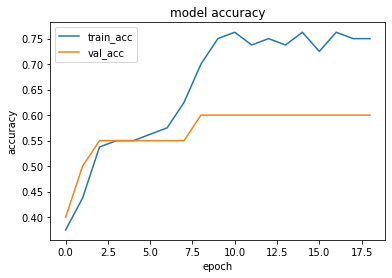

1it [00:00, 17623.13it/s]


prediction for video armflapping_1.mov is [[0.4973131]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.5470483]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.41207683]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.13522986]]


1it [00:00, 17924.38it/s]


prediction for video control_2.mov is [[0.7449312]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.21489751]]
Epoch 1/75
3/3 [==============================] - 1s 212ms/step - loss: 0.6953 - accuracy: 0.5500 - precision_50: 0.5455 - recall_50: 0.6000 - val_loss: 0.6655 - val_accuracy: 0.7500 - val_precision_50: 0.7778 - val_recall_50: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6624 - accuracy: 0.6625 - precision_50: 0.6275 - recall_50: 0.8000 - val_loss: 0.6554 - val_accuracy: 0.7500 - val_precision_50: 0.7778 - val_recall_50: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6628 - accuracy: 0.6625 - precision_50: 0.6226 - recall_50: 0.8250 - val_loss: 0.6460 - val_accuracy: 0.7500 - val_precision_50: 0.7778 - val_recall_50: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6368 - accuracy: 0.6875 - precision_50: 0.6471 - recall_50: 0.8250 - val_loss: 0.6377 - val_accuracy: 0.7500 - val_precision_50: 0.7778 - val_recall_50: 0.7000
Epoch 5/75


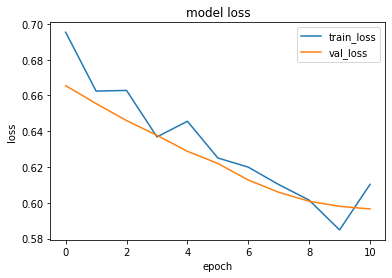

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.47338265]]


1it [00:00, 17331.83it/s]


prediction for video armflapping_3.mov is [[0.5032978]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.41375467]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.38876987]]


1it [00:00, 10645.44it/s]


prediction for video control_2.mov is [[0.57410496]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.36272174]]
Epoch 1/75
3/3 [==============================] - 1s 205ms/step - loss: 0.6973 - accuracy: 0.5125 - precision_51: 0.5227 - recall_51: 0.5610 - val_loss: 0.6878 - val_accuracy: 0.8000 - val_precision_51: 0.6923 - val_recall_51: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6867 - accuracy: 0.5500 - precision_51: 0.5410 - recall_51: 0.8049 - val_loss: 0.6707 - val_accuracy: 0.8000 - val_precision_51: 0.6923 - val_recall_51: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6667 - accuracy: 0.6125 - precision_51: 0.5781 - recall_51: 0.9024 - val_loss: 0.6587 - val_accuracy: 0.7500 - val_precision_51: 0.6429 - val_recall_51: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6589 - accuracy: 0.6500 - precision_51: 0.6032 - recall_51: 0.9268 - val_loss: 0.6475 - val_accuracy: 0.8000 - val_precision_51: 0.6923 - val_recall_51: 1.0000
Epoch 5/75


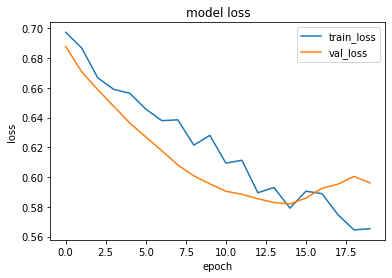

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.31804904]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_3.mov is [[0.5573717]]


1it [00:00, 18808.54it/s]


prediction for video armflapping_2.mov is [[0.22467828]]


1it [00:00, 18236.10it/s]


prediction for video control_1.mov is [[0.14658126]]


1it [00:00, 10512.04it/s]


prediction for video control_2.mov is [[0.7738246]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.17020366]]
Epoch 1/75
3/3 [==============================] - 1s 205ms/step - loss: 0.6944 - accuracy: 0.6500 - precision_52: 0.6154 - recall_52: 0.8000 - val_loss: 0.6560 - val_accuracy: 0.8500 - val_precision_52: 0.8182 - val_recall_52: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6708 - accuracy: 0.7000 - precision_52: 0.7000 - recall_52: 0.7000 - val_loss: 0.6564 - val_accuracy: 0.8500 - val_precision_52: 0.8182 - val_recall_52: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6689 - accuracy: 0.6875 - precision_52: 0.6744 - recall_52: 0.7250 - val_loss: 0.6519 - val_accuracy: 0.8000 - val_precision_52: 0.8000 - val_recall_52: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6455 - accuracy: 0.7125 - precision_52: 0.7297 - recall_52: 0.6750 - val_loss: 0.6454 - val_accuracy: 0.7500 - val_precision_52: 0.7778 - val_recall_52: 0.7000
Epoch 5/75


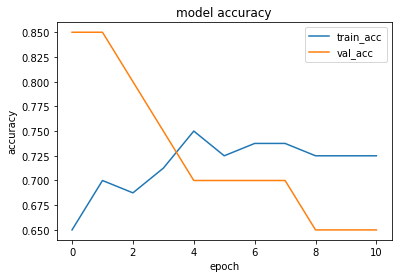

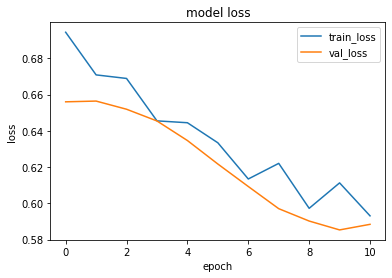

1it [00:00, 17924.38it/s]


prediction for video armflapping_1.mov is [[0.5416412]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.5663041]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.19495678]]


1it [00:00, 17476.27it/s]


prediction for video control_1.mov is [[0.0961476]]


1it [00:00, 13148.29it/s]


prediction for video control_2.mov is [[0.79864144]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.25880736]]
Epoch 1/75
3/3 [==============================] - 1s 204ms/step - loss: 0.6935 - accuracy: 0.4750 - precision_53: 0.3571 - recall_53: 0.1316 - val_loss: 0.6914 - val_accuracy: 0.4500 - val_precision_53: 1.0000 - val_recall_53: 0.0833
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6918 - accuracy: 0.5375 - precision_53: 0.5333 - recall_53: 0.2105 - val_loss: 0.6697 - val_accuracy: 0.8000 - val_precision_53: 0.9000 - val_recall_53: 0.7500
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6681 - accuracy: 0.7625 - precision_53: 0.7436 - recall_53: 0.7632 - val_loss: 0.6534 - val_accuracy: 0.7500 - val_precision_53: 0.8182 - val_recall_53: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6604 - accuracy: 0.7375 - precision_53: 0.7073 - recall_53: 0.7632 - val_loss: 0.6387 - val_accuracy: 0.7000 - val_precision_53: 0.7143 - val_recall_53: 0.8333
Epoch 5/75


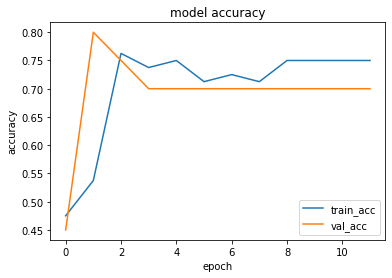

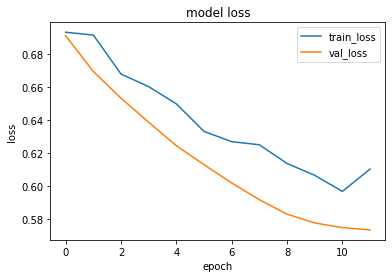

1it [00:00, 18641.35it/s]


prediction for video armflapping_1.mov is [[0.25829226]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.5288729]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_2.mov is [[0.19567397]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.12851873]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.8015698]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.15570688]]


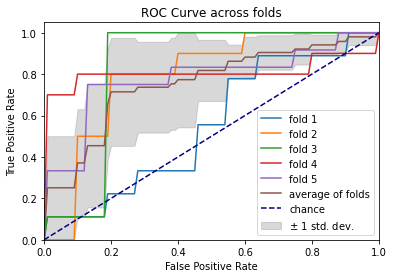

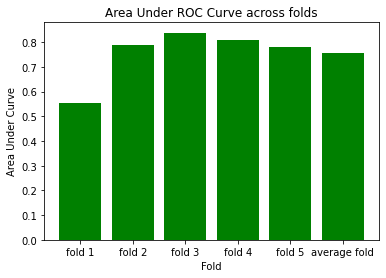

In [32]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 246ms/step - loss: 0.6607 - accuracy: 0.5750 - precision_55: 0.5538 - recall_55: 0.8780 - val_loss: 0.7031 - val_accuracy: 0.5500 - val_precision_55: 0.5000 - val_recall_55: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6376 - accuracy: 0.6750 - precision_55: 0.6415 - recall_55: 0.8293 - val_loss: 0.7034 - val_accuracy: 0.6000 - val_precision_55: 0.5385 - val_recall_55: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6136 - accuracy: 0.7000 - precision_55: 0.6545 - recall_55: 0.8780 - val_loss: 0.7137 - val_accuracy: 0.6000 - val_precision_55: 0.5385 - val_recall_55: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.5975 - accuracy: 0.7125 - precision_55: 0.6667 - recall_55: 0.8780 - val_loss: 0.7211 - val_accuracy: 0.6000 - val_precision_55: 0.5385 - val_recall_55: 0.7778
Epoch 5/75
3/3 [==============================] - 0s 139ms/step 

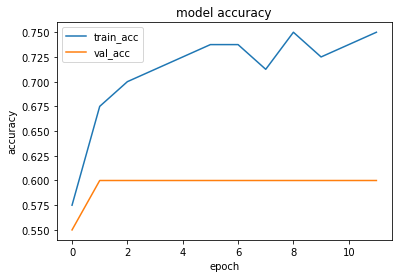

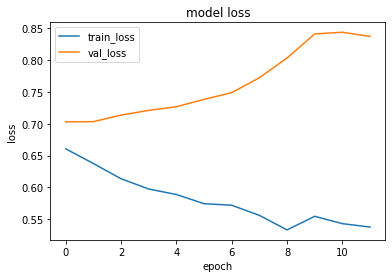

1it [00:00, 17924.38it/s]


prediction for video armflapping_1.mov is [[0.5836066]]


1it [00:00, 12633.45it/s]


prediction for video armflapping_3.mov is [[0.5314006]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.49944255]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.33248585]]


1it [00:00, 17476.27it/s]


prediction for video control_2.mov is [[0.640984]]


1it [00:00, 13148.29it/s]


prediction for video control_3.mov is [[0.44489342]]
Epoch 1/75
3/3 [==============================] - 1s 243ms/step - loss: 0.6940 - accuracy: 0.4000 - precision_56: 0.4200 - recall_56: 0.5250 - val_loss: 0.6715 - val_accuracy: 0.6000 - val_precision_56: 0.5556 - val_recall_56: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6864 - accuracy: 0.4625 - precision_56: 0.4769 - recall_56: 0.7750 - val_loss: 0.6672 - val_accuracy: 0.5500 - val_precision_56: 0.5263 - val_recall_56: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6655 - accuracy: 0.5500 - precision_56: 0.5263 - recall_56: 1.0000 - val_loss: 0.6599 - val_accuracy: 0.5500 - val_precision_56: 0.5263 - val_recall_56: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6566 - accuracy: 0.5750 - precision_56: 0.5455 - recall_56: 0.9000 - val_loss: 0.6502 - val_accuracy: 0.6500 - val_precision_56: 0.6364 - val_recall_56: 0.7000
Epoch 5/75


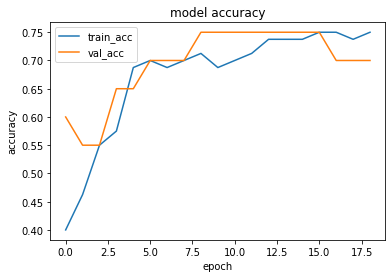

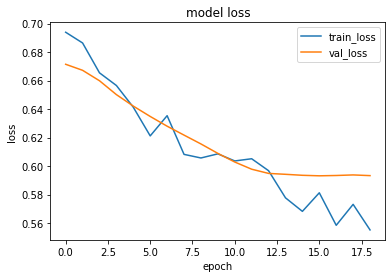

1it [00:00, 13148.29it/s]


prediction for video armflapping_1.mov is [[0.4500544]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.55421925]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_2.mov is [[0.3486182]]


1it [00:00, 17189.77it/s]


prediction for video control_1.mov is [[0.18634307]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.77408147]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.26316106]]
Epoch 1/75
3/3 [==============================] - 1s 227ms/step - loss: 0.7076 - accuracy: 0.4250 - precision_57: 0.3684 - recall_57: 0.1707 - val_loss: 0.6743 - val_accuracy: 0.5500 - val_precision_57: 0.5000 - val_recall_57: 0.5556
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6888 - accuracy: 0.4875 - precision_57: 0.5000 - recall_57: 0.5854 - val_loss: 0.6578 - val_accuracy: 0.6000 - val_precision_57: 0.5294 - val_recall_57: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6798 - accuracy: 0.5625 - precision_57: 0.5455 - recall_57: 0.8780 - val_loss: 0.6430 - val_accuracy: 0.6000 - val_precision_57: 0.5294 - val_recall_57: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6536 - accuracy: 0.5500 - precision_57: 0.5342 - recall_57: 0.9512 - val_loss: 0.6292 - val_accuracy: 0.6000 - val_precision_57: 0.5294 - val_recall_57: 1.0000
Epoch 5/75


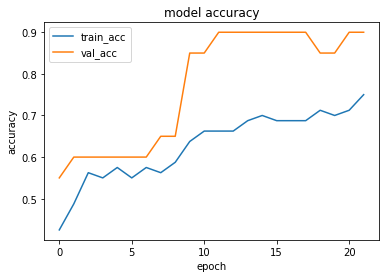

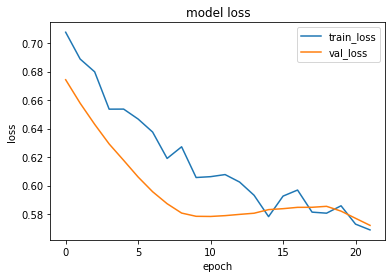

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.3020187]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_3.mov is [[0.56310487]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.24153283]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.17249617]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.84675467]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.1930233]]
Epoch 1/75
3/3 [==============================] - 1s 235ms/step - loss: 0.6899 - accuracy: 0.5125 - precision_58: 0.5091 - recall_58: 0.7000 - val_loss: 0.6600 - val_accuracy: 0.5500 - val_precision_58: 0.5263 - val_recall_58: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6674 - accuracy: 0.5375 - precision_58: 0.5238 - recall_58: 0.8250 - val_loss: 0.6531 - val_accuracy: 0.5000 - val_precision_58: 0.5000 - val_recall_58: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6588 - accuracy: 0.5875 - precision_58: 0.5522 - recall_58: 0.9250 - val_loss: 0.6423 - val_accuracy: 0.5000 - val_precision_58: 0.5000 - val_recall_58: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6526 - accuracy: 0.6000 - precision_58: 0.5571 - recall_58: 0.9750 - val_loss: 0.6352 - val_accuracy: 0.5000 - val_precision_58: 0.5000 - val_recall_58: 1.0000
Epoch 5/75
3

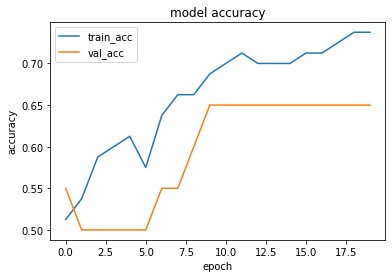

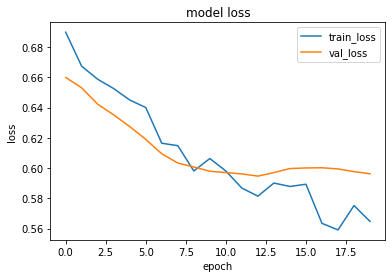

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.45297638]]


1it [00:00, 17772.47it/s]


prediction for video armflapping_3.mov is [[0.6029949]]


1it [00:00, 17772.47it/s]


prediction for video armflapping_2.mov is [[0.26159385]]


1it [00:00, 16710.37it/s]


prediction for video control_1.mov is [[0.07775044]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.7489196]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.3160294]]
Epoch 1/75
3/3 [==============================] - 1s 221ms/step - loss: 0.7038 - accuracy: 0.5750 - precision_59: 0.5588 - recall_59: 0.5000 - val_loss: 0.6670 - val_accuracy: 0.7500 - val_precision_59: 0.7692 - val_recall_59: 0.8333
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6770 - accuracy: 0.6875 - precision_59: 0.6512 - recall_59: 0.7368 - val_loss: 0.6560 - val_accuracy: 0.6500 - val_precision_59: 0.6923 - val_recall_59: 0.7500
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6626 - accuracy: 0.7125 - precision_59: 0.6667 - recall_59: 0.7895 - val_loss: 0.6469 - val_accuracy: 0.6500 - val_precision_59: 0.6923 - val_recall_59: 0.7500
Epoch 4/75
3/3 [==============================] - 1s 228ms/step - loss: 0.6600 - accuracy: 0.6750 - precision_59: 0.6364 - recall_59: 0.7368 - val_loss: 0.6365 - val_accuracy: 0.6500 - val_precision_59: 0.6923 - val_recall_59: 0.7500
Epoch 5/75
3

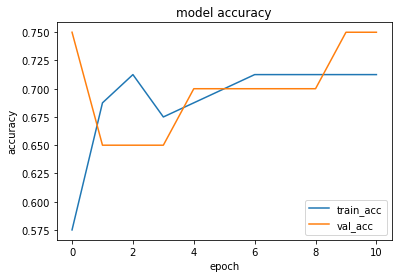

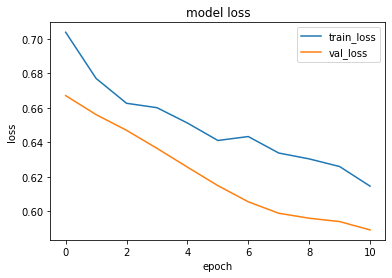

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.3389334]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_3.mov is [[0.54869366]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.24142197]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.1285724]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.7233822]]


1it [00:00, 19239.93it/s]

prediction for video control_3.mov is [[0.20186913]]


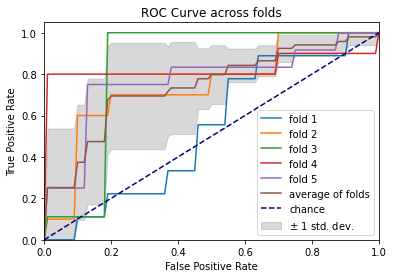

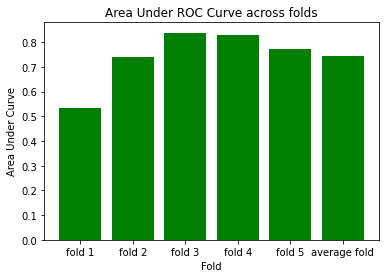

In [33]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])